<a href="https://colab.research.google.com/github/cerezamo/NLP_brouillon/blob/master/Camembert_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CamemBERT classification model 


In [33]:
import spacy 
import numpy as np 
import pandas as pd 
import os 
os.getcwd()
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Set up Colab GPU 

In [34]:
#%tensorflow_version 1.x
# First you should go in 'Edit' -> 'Notebook settings' -> Add device GPU
import tensorflow as tf


# GPU device name.
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

Let's now tell torch that one GPU is available 

In [35]:
import torch

if torch.cuda.is_available():  
        
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


Please check GPU capacity that you were given. You might want to reduce the batch size further in the code. 

Let's install the Hugging Face Library transformer package 

In [36]:
! pip install transformers 

### Loading our corpus and preprocessing 

In [0]:
# Import medium_df_desq in "files" (on the left) => ICI prendre du github ??
import pandas as pd

# Load the dataset into a pandas dataframe.
df=pd.read_csv('medium_df_deseq.csv',encoding='utf-8')

# We replace the labels in a more normalized way : 0=men, 1=women 
df.sexe=df.sexe.replace(1,0)
df.sexe=df.sexe.replace(2,1)


In [0]:
# Make results reproducible 
seed_val = 2020

In [39]:
df.columns

Index(['Unnamed: 0', 'Id', 'Titre', 'Type', 'Theme', 'Prenom', 'Nom',
       'Fonction', 'Date', 'Tags', 'Texte', 'Lien', 'PRENOM', 'preusuel',
       'sexe'],
      dtype='object')

In [0]:
def unbalanced_preprocess(df,seed_val,frac_val):

  from sklearn.model_selection import train_test_split

  #Shuffle the data 
  df_unbalanced=df.sample(frac=frac_val).reset_index()

  # Reduce to the variables we are interested in 
  df_unbalanced=df_unbalanced[['Texte','sexe']]

  # Report the number of speeches in the corpus.
  print('Number of text in the unbalanced corpus : {:,}\n'.format(df_unbalanced.shape[0]))
  prop = (len(df_unbalanced[df_unbalanced.sexe==1])/len(df_unbalanced))*100
  print('Proportions of women in the unbalanced corpus : {}\n'.format(prop))

  return df_unbalanced

In [45]:
df_unbalanced = unbalanced_preprocess(df,seed_val,frac_val=0.5)

Number of text in the unbalanced corpus : 2,500

Proportions of women in the unbalanced corpus : 25.319999999999997



In [0]:
def balanced_preprocess(df,seed_val,frac_val):
  from sklearn.model_selection import train_test_split

  # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  #Shuffle the data and taking half of the sample in order not to have to many data compared to the other samples 
  df_balanced=df.sample(frac=1,random_state=seed_val).reset_index()

  # Reduce to the variables we are interested in 
  df_balanced=df_balanced[['Texte','sexe']]

  # Report the number of speeches in the corpus.
  print('Number of text in this corpus : {:,}\n'.format(df_balanced.shape[0]))
  prop = (len(df_balanced[df_balanced.sexe==1])/len(df_balanced))*100
  print('Proportions of women in the balanced corpus : {}\n'.format(prop))

  return df_balanced



In [47]:
df_balanced = balanced_preprocess(df,seed_val,frac_val=1)

Number of text in this corpus : 2,500

Proportions of women in the balanced corpus : 50.0



In [0]:
def balanced_splitted(df,seed_val,frac_val):
    # Let's take a balanced sample 
  df_m = df.loc[df['sexe'] == 0]
  df_f = df.loc[df['sexe'] == 1] 
  df_m = df_m[0:len(df_f)]
  df = df_f.append(df_m)

  #We shuffle the data
  df=df.sample(frac=1,random_state=seed_val).reset_index()

  from itertools import repeat
  n=2500
  chunks, label_split,index_df=[],[],[]
  j=0
  for text in df.Texte :
      txt=[text[i:i+n] for i in range(0, len(text), n)]
      chunks.append(txt)
      label_split.extend(repeat(df.sexe[j], len(txt)))
      # We keep track of the text Id from the first database
      index_df.extend(repeat(df.Id[j], len(txt)))
      j+=1

  chunks = [item for sublist in chunks for item in sublist]
  df=pd.DataFrame([chunks,label_split,index_df]).transpose()
  df.columns=['Texte','sexe','index_df']
  df['sexe'] = df['sexe'].astype(int)

  df=df.sample(frac=frac_val,random_state=seed_val).reset_index()

  df_balanced_split= df

  # Report the number of speeches in the corpus.
  print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
  prop = (len(df_balanced_split[df_balanced_split.sexe==1])/len(df_balanced_split))*100
  print('Proportions of women in the balanced splitted corpus : {}\n'.format(prop))

  return df_balanced_split

In [68]:
df_balanced_split = balanced_splitted(df,seed_val,frac_val=0.2)[['Texte','sexe']]

Number of text in this balanced splitted corpus : 2,528

Proportions of women in the balanced splitted corpus : 52.76898734177215



**We propose 3 samples to train our model :**


1.   **Unbalanced sample**

We take the raw data without any further treatment.

2.   **Balanced sample**

The second option consist in deleting randomly part of male speeches in order to get a balanced sample. Indeed, in the case of unbalanced sample our model could decide to classify all speakers in the male category which would lead to a 0.75 accuracy in our case study. In order to avoid this we feed the model with the same proportions of male and female speakers. Other kind of treatments exist to deal with unbalanced sample. This one is the simpliest one and we could argue that there is a possibility that the deleted sample contains important information that we therefore miss. However we believe that in our case this is not a big issue. Our unbalanced sample is quite large for both female and male.

3. **Balanced and splitted sample**

The third option is a response to the max length constraint of BERT models. Our text samples are big and contain much more tokens than the 512 limit. In the first two options we decide to just feed the model with the 512 first tokens and thus delete the rest of them. In this third option we cut the text into x parts containing 500 tokens each. All parts of the speech will serve to feed the model. By this technique we do not loose potential important informations at the end of the text. A lot of other techniques have been employed (see ref !!! PUT). We decide to stick to this one in this project. 



#### Tokenization of our text and preparing to feed CamemBERT

#### Loading the Camembert Tokenizer

In [0]:
# Import Camembert tokenizer
from transformers import CamembertTokenizer
# We choose a right padding side for the moment and we will test for a left padding side on a second stage
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

In [0]:
# Print the original text.
print(' Original: ', df.Texte[0])

# Print the text split into tokens.
print('Tokenized: ', tokenizer.tokenize(df.Texte[0]))

# Print the text mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df.Texte[0])))

 Original:  Messieurs,Je suis heureux de vous saluer. Quand je dis que je suis heureux de vous saluer, ce n'est pas une simple affirmation de politesse. Je le disais à l'instant à Monsieur le Ministre de la Défense, M. Richard, c'est pour moi un instant où il y a un peu d'émotion; je vais vous dire pourquoi.Vous êtes la première classe d'âge qui ne fera pas de service militaire. C'est une décision que j'ai prise, il y a deux ans, après une vraie réflexion et un vrai débat. Après tout, le service militaire c'est une vieille tradition nationale, il était plus que centenaire. Il y avait toutes sortes de raisons à cela, notamment la nécessité d'avoir une armée nombreuse et donc d'avoir des jeunes formés aux combats, à l'utilisation des armes de l'époque.On pouvait s'interroger sur la nécessité de poursuivre dans cette voie. Il y avait naturellement des critiques, il y avait beaucoup de jeunes qui se disaient qu'ils perdaient un peu leur temps, d'autres qui étaient satisfaits. Mais il y ava

#### Adding special tokens to the start and end of the text


Preprocessing steps : 


1.   **Add special tokens [CLS] [SEP]** 

According to the documentation we need to add special tokens to the start and end of the text Moreover, for camembert we should add a space between CLS and the first token (not sure here, we have to ask benjamin). 

2.   **Pad and truncate all texts to a single number**

Pretrained transformes like Camembert only accept input of the same length. Our corpus contains large texts and we have to pad them in order to be able to feed Camembert. We will set the max length to a large number in order to get all information possible in the text. We choose a max length of 500 which is almost the maximum (512) "sentence" length  accepted. We are aware that this choice will impact a lot training speed.

3.   **Construct an attention mask**

Attention masks are just set to 1 when the token have to be analyzed and 0 otherwise (padded tokens). All our attention mask should be 1 with this corpus. 



For sake of simplicity and to avoid errors we will use the function encode_plus of the library which is really convenient. 



#### Length and attention mask 

In [0]:
def prepare_to_feed(df,length,batch_size_value):
  from torch.utils.data import TensorDataset, random_split
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

  texts = df.Texte.values
  labels = df.sexe.values

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  num_truncated_tokens =[]
  # Apply function to our corpus
  for text in texts:
      encoded_dict = tokenizer.encode_plus(
                          text,                      # text
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = length,           # We choose for now a max length of 500.
                          pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                          return_attention_mask = True,   # Construct attention masks
                          return_tensors = 'pt',     # Return pytorch tensors.
                          return_overflowing_tokens =True, # return overflowing token information
                    )
      
      # Map tokens to their id in the dictionnary 
      # We add this to our list    
      input_ids.append(encoded_dict['input_ids'])
  
      #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
      
      # 3. Attention masks
      attention_masks.append(encoded_dict['attention_mask'])

  # We convert all this into tensors in order to be able to make it work on GPU 
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Original text and transformed tensor print 
  print("Let's check for the first text indexes, attention masks and labels")
  print(" ")
  print('Original: ', texts[0][0:100])
  print('IDs:', input_ids[0][0:100])
  print('Attention masks:', attention_masks[0][0:100])
  print('labels',labels[0])


  # Combine all above
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # Let's create a 80-20 train / validation dataset 
  train_size = int(0.8 * len(dataset))
  val_size = len(dataset) - train_size

  train_set, val_set = random_split(dataset, [train_size, val_size])


  print("-------------------------------------------------")
  print(" ")
  print("How many texts do we have in the train and validation sample ? ")
  print(" ")
  print('We have {} training texts'.format(train_size))
  print('We have {} validation texts'.format(val_size))
  print(" ")
  print("-------------------------------------------------")

  # We set the size of the batch ( usually set around 16 or 32), we will take the lower bound because of the large text length
  batch_size = batch_size_value

  # We create data loaders for the train and validation dataset. 
  train_dataloader = DataLoader(
              train_set,  # The training samples.
              sampler = RandomSampler(train_set), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  val_dataloader = DataLoader(
              val_set, # The validation samples.
              sampler = SequentialSampler(val_set), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  
  print('Data loaders created for train [0] and val [1]')

  return train_dataloader, val_dataloader 

In [0]:
print('############### Unbalanced sample ################')
train_loader_unbalanced, val_loader_unbalanced = prepare_to_feed(df_unbalanced,length=500,batch_size_value=2)

############### Unbalanced sample ################
Let's check for the first text indexes, attention masks and labels
 
Original:  Monsieur le Préfet, Monsieur le Président du Conseil régional, Monsieur le Président de l'Associatio
IDs: tensor([    5,  2445,    16, 25230,     7,  2445,    16,  1850,    25,   960,
         4124,     7,  2445,    16,  1850,     8,    17,    11,  3969,    20,
         4678,    10,     8,   184,     7, 19923,    19,  1850,    10,     8,
         4678,    10,     7,  4348,    13, 28499,    35,     8,    13, 19641,
         1467,     7, 23605,    14, 15867,    19, 12680,     7, 23605,    14,
        15867,    19,  6664,  3980,     7,  6684,    10,  9402,    80,    14,
        15867,    19,  3454,     7, 23605,    14, 19923,     7,   228,    11,
           41,    42,   217,     8,   593,    27,    50,   146,   405,    11,
          265,    42,    39,    15,  5155,     7,    24,    16,  9280,     8,
         3864,     8,    13,  4732,  1230,  8820,  1461,    2

In [0]:
print('############### Balanced sample ################')
train_loader_balanced, val_loader_balanced = prepare_to_feed(df_balanced,length=500,batch_size_value=2)

############### Balanced sample ################
Let's check for the first text indexes, attention masks and labels
 
Original:  Mesdames et Messieurs les Ministres,Monsieur le Chef de l'opposition,Mesdames et Messieurs les Secré
IDs: tensor([    5, 23605,    14, 19923,    19,  6375,    10,     7, 31609,    16,
         6238,     8,    17,    11,  4244,     7,  6684,    10,  9402,    80,
           14, 19923,    19, 11907,    10,  2348,     7, 31609,    16,  4860,
           26,  7383,  4975,    10,  1114,  4681,     7,  3181,  9402,    35,
           13,  6238,     8,  9013,     8,    13,  6854,     8,    13,  2358,
         1467,     7, 31609,    16,  1850,    25,   960,  4124,     8,    13,
         6873,     7,    14,  4348,  3181,  9402,    35,    14,  2445,    19,
        15538,    26, 22778,    10,    25,   960,  4124,     7, 31609,    17,
           11, 16336,   297,     7,  4212,  2242,  2650, 20112,  4613,    10,
            7,  3696,    10, 12784,     7,  1684,    45,    52,

In [0]:
print('############### Balanced sample split ################')
train_loader_balanced_split, val_loader_balanced_split = prepare_to_feed(df_balanced_split,length=500,batch_size_value=2)

############### Balanced sample split ################
Let's check for the first text indexes, attention masks and labels
 
Original:  tions un dispositif permettant l'équilibre entre des exigences de sûreté particulièrement élevées et
IDs: tensor([    5,    21,  6279,    23,  2507,  1177,    17,    11,  4786,   128,
           20,  3768,     8, 15850,    21,   937, 12187,    14,    19,   979,
           20,   699,     9,   228,    11,    41,   590,     7,    50,   441,
           27,    19, 27696,    10,    31,    56,  5989,     8,  1222,    29,
           19,  2001,  6793, 16671,   245,     8,   242, 12117, 15910,    80,
            9,  5076,  2170,    50,   920,    27,    17,    11,    88,   218,
          119,   756,    36,   533,     8,    13, 15850, 14248, 13895,     9,
          100,   555,    27,    50,   672,  1733,    32,    39,    14,    27,
           39,   978,   138,  5205,   131,    15,   129,  7030,    24,    22,
        15881,     7,    29,    19,  6511,   274,     7, 

5 and 6 seem to be the [CLS] and [SEP] special tokens 


### CamemBERT Sequence Classification model tuning


#### Loading the model


We will finally build up our model. We will use the  CamemBERT model for sequence classification which includes a special top layer designed for this task. 

In [0]:
# Importing from transformers
from transformers import CamembertForSequenceClassification, CamembertConfig

In [0]:
# Loading the model
gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [0]:
# We run the model on the colab GPU 
gender_model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

Optimizers and Loss

#### Constructing the training and validation loop 


In [0]:
import numpy as np

from sklearn.metrics import f1_score 

from sklearn.metrics import roc_auc_score 

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def flat_f1_score(labels,preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat,pred_flat,zero_division=1)

def flat_roc_auc(labels,preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return roc_auc_score(labels_flat,pred_flat,zero_division=0.5)


In [0]:

gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, 
)

In [0]:
def train_val_gendermodel(train_loader, val_loader, epochs_val,seed_val,device,lr_value):

  ############################  IMPORT MODEL ################################################
  gender_model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", 
    num_labels = 2, # We have two different labels Women = 1 and Men =0   
    output_attentions = False, 
    output_hidden_states = False, )

  model = gender_model
  model.cuda()
  
  ############################## RANDOM SEED ##################################################

  import random
 # Let's put a seed to make this result reproducible 
  seed=seed_val
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  ############################### LEARNING RATE SCHEDULER #######################################

  # https://huggingface.co/transformers/migration.html 
  # https://pytorch.org/docs/stable/optim.html (default values)

  import torch.nn as nn
  import torch.optim as optim
  from transformers import AdamW
  from transformers import get_linear_schedule_with_warmup

  epochs = epochs_val # In order to fine tune our model we will first set the number of epochs to 4.

  # We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
  criterion = nn.BCEWithLogitsLoss()
  #Implements Adam algorithm with weight decay fix.
  opti = AdamW(model.parameters(),
                    lr =lr_value, # learning rate (default = 1e-3)
                    eps = 1e-8 # prevents division by 0 (default = 1e-8)
                  )

  num_training_steps = len(train_loader) * epochs
  # Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
  scheduler = get_linear_schedule_with_warmup(opti, 
                                              num_warmup_steps = 0,
                                              num_training_steps = num_training_steps)
    

  # We want to evaluate the training phase 
  training_stats = []

  for ep in range(0, epochs):
    print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
    print('Training starts')

    ################################### TRAINING ################################

    #Put the model in training mode
    model.train()

    # Set the train loss for the epoch to 0 
    total_train_loss = 0

    for step, batch in enumerate(train_loader):
      # Clear gradients 
      model.zero_grad() # (opti.zerograd ? )

      # Cpy the 3 batch to GPU 
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      #return loss and logits
      loss, logits = model(b_input_ids, 
                          token_type_ids=None, 
                          attention_mask=b_input_mask, 
                          labels=b_labels) 
      
      # Accumulate training loss for all batches 
      total_train_loss += loss.item()

      #Backpropagating the gradients 
      loss.backward()

      # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Update parameters 
      opti.step()

      # Update learning rate schedule
      scheduler.step()

    #Calculate the average training loss over all batches  
    avg_train_loss = total_train_loss / len(train_loader)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print('')
    print('And now, validation STARTS')

    ###################### VALIDATION #############################

    # Put model in evaluation mode 
    model.eval()

    # Set statistics to 0
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    total_eval_f1=0
    total_roc_auc = 0 

    # Confusion matrix ?
    predictions, true_labels = [], []

    for batch in val_loader:
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      
      # We don't care about gradients for eval

      with torch.no_grad(): 
        (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
      total_eval_loss += loss.item()

        # Move logits and labels to CPU 
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      pred_flat = np.argmax(logits, axis=1).flatten()
      labels_flat = label_ids.flatten()

      # Confusion matrix ?
      #val_batch_preds = np.argmax(logits, axis=1)
      #val_batch_labels = label_ids
      #predictions.extend(val_batch_preds)
      #true_labels.extend(val_batch_labels)

      # Accumulation accuracy for all batch
      total_eval_accuracy += flat_accuracy(logits, label_ids)

      # Accumulation f1 for all batch
      total_eval_f1 += f1_score(labels_flat,pred_flat,zero_division=1)

      # Accumulation roc_auc for all batch
      #total_roc_auc += flat_roc_auc(label_ids,logits)
      
      #Final accuracy on all batch
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      #Final f1 on all batch
    avg_val_f1 = total_eval_f1 / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_f1))

     #Final roc_auc over all batch
    #avg_val_roc_auc = total_roc_auc / len(val_loader)
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))

      #Final loss over all batch
    avg_val_loss = total_eval_loss / len(val_loader)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))

    # confusion matrix ? 
    pred_tags = [i for i in predictions]
    valid_tags = [i for i in true_labels]



    training_stats.append(
          {
              'epoch': ep + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Valid F1' : avg_val_f1,
             # 'Valid ROC AUC' : avg_val_roc_auc,
          }
      )

  print("")
  print("Done !")

  return  training_stats

In [0]:
results_unbalanced = train_val_gendermodel(train_loader=train_loader_unbalanced, val_loader=val_loader_unbalanced, epochs_val=4,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 4 ==============
Training starts

  Average training loss: 0.59

And now, validation STARTS
  Accuracy: 0.79
  Accuracy: 0.67
  Validation Loss: 0.61
===========Starting Epoch 2 / 4 ==============
Training starts

  Average training loss: 0.53

And now, validation STARTS
  Accuracy: 0.81
  Accuracy: 0.69
  Validation Loss: 0.64
===========Starting Epoch 3 / 4 ==============
Training starts

  Average training loss: 0.45

And now, validation STARTS
  Accuracy: 0.83
  Accuracy: 0.72
  Validation Loss: 0.62
===========Starting Epoch 4 / 4 ==============
Training starts

  Average training loss: 0.32

And now, validation STARTS
  Accuracy: 0.82
  Accuracy: 0.71
  Validation Loss: 0.77

Done !


In [0]:
import pandas as pd

In [0]:
df_stats = pd.DataFrame(data=results_unbalanced)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Valid F1
epoch,,,,
1,0.593989,0.608205,0.787755,0.670748
2,0.525662,0.642845,0.812245,0.691156
3,0.452452,0.616325,0.830612,0.717007
4,0.318853,0.771008,0.824490,0.710204


In [0]:
results_balanced = train_val_gendermodel(train_loader=train_loader_balanced, val_loader=val_loader_balanced, epochs_val=4,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 4 ==============
Training starts

  Average training loss: 0.69

And now, validation STARTS
  Accuracy: 0.68
  Accuracy: 0.59
  Validation Loss: 0.89
===========Starting Epoch 2 / 4 ==============
Training starts

  Average training loss: 0.66

And now, validation STARTS
  Accuracy: 0.77
  Accuracy: 0.69
  Validation Loss: 0.52
===========Starting Epoch 3 / 4 ==============
Training starts

  Average training loss: 0.54

And now, validation STARTS
  Accuracy: 0.74
  Accuracy: 0.67
  Validation Loss: 0.74
===========Starting Epoch 4 / 4 ==============
Training starts

  Average training loss: 0.35

And now, validation STARTS
  Accuracy: 0.76
  Accuracy: 0.67
  Validation Loss: 1.10

Done !


In [0]:
df_stats = pd.DataFrame(data=results_balanced)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Valid F1
epoch,,,,
1,0.690740,0.886900,0.681633,0.585034
2,0.659529,0.520504,0.771429,0.688435
3,0.541589,0.739033,0.744898,0.672109
4,0.353204,1.095774,0.755102,0.670748


In [0]:
results_balanced_split = train_val_gendermodel(train_loader=train_loader_balanced_split, val_loader=val_loader_balanced_split, epochs_val=4,seed_val=2020,device=device,lr_value=5e-5)

===========Starting Epoch 1 / 4 ==============
Training starts

  Average training loss: 0.70

And now, validation STARTS
  Accuracy: 0.74
  Accuracy: 0.68
  Validation Loss: 0.69
===========Starting Epoch 2 / 4 ==============
Training starts

  Average training loss: 0.56

And now, validation STARTS
  Accuracy: 0.77
  Accuracy: 0.73
  Validation Loss: 0.85
===========Starting Epoch 3 / 4 ==============
Training starts

  Average training loss: 0.41

And now, validation STARTS
  Accuracy: 0.80
  Accuracy: 0.74
  Validation Loss: 0.85
===========Starting Epoch 4 / 4 ==============
Training starts

  Average training loss: 0.20

And now, validation STARTS
  Accuracy: 0.81
  Accuracy: 0.75
  Validation Loss: 1.00

Done !


In [0]:
df_stats = pd.DataFrame(data=results_balanced_split)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Valid F1
epoch,,,,
1,0.695822,0.690138,0.737903,0.677419
2,0.556895,0.851728,0.768145,0.729839
3,0.412280,0.850640,0.796371,0.736559
4,0.201848,1.000318,0.808468,0.752688


Analyse

#### Saving the model ?

## Evaluation and qualitative analysis 

In this section we train the model according to what we have infered from the previous section. Moreover we will evaluate our model qualitatively on a little development sample. 

In [69]:
df_eval=balanced_splitted(df,seed_val=2020,frac_val=1)

Number of text in this balanced splitted corpus : 12,641

Proportions of women in the balanced splitted corpus : 51.41998259631359



In [75]:
len_train = round(0.98*len(df_eval))
len_dev = len(df_eval) - len_train
len_train, len_dev

(12388, 253)

In [76]:
df_balanced_split= df_eval[0:len_train]
dev_balanced_split=df_eval[len_train:len(df_eval)]

# Report the number of speeches in the corpus.
print('Number of text in this balanced splitted corpus : {:,}\n'.format(df_balanced_split.shape[0]))
print('Number of text in the development sample : {:,}\n'.format(dev_balanced_split.shape[0]))

Number of text in this balanced splitted corpus : 12,388

Number of text in the development sample : 253



In [0]:
def prepare_to_feed_train(df,length,batch_size_value):
  from transformers import CamembertTokenizer
  from torch.utils.data import TensorDataset, random_split
  from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

  texts = df_eval.Texte.values
  labels = df_eval.sexe.values
  tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right') #left

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []
  num_truncated_tokens =[]
  # Apply function to our corpus
  for text in texts:
      encoded_dict = tokenizer.encode_plus(
                          text,                      # text
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = length,           # We choose for now a max length of 500.
                          pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                          return_attention_mask = True,   # Construct attention masks
                          return_tensors = 'pt',     # Return pytorch tensors.
                          return_overflowing_tokens =True, # return overflowing token information
                    )
      
      # Map tokens to their id in the dictionnary 
      # We add this to our list    
      input_ids.append(encoded_dict['input_ids'])
  
      #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
      
      # 3. Attention masks
      attention_masks.append(encoded_dict['attention_mask'])

  # We convert all this into tensors in order to be able to make it work on GPU 
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Original text and transformed tensor print 
  print("Let's check for the first text indexes, attention masks and labels")
  print(" ")
  print('Original: ', texts[0][0:100])
  print('IDs:', input_ids[0][0:100])
  print('Attention masks:', attention_masks[0][0:100])
  print('labels',labels[0])


  # Combine all above
  dataset = TensorDataset(input_ids, attention_masks, labels)

  # We create data loaders for the train and validation dataset. 
  train_dataloader = DataLoader(
              dataset,  # The training samples.
              sampler = SequentialSampler(dataset), 
              batch_size = batch_size_value # Trains with this batch size.
          )
  
  print('Data loaders created for train [0]')

  return train_dataloader

In [80]:
train_loader_balanced_split= prepare_to_feed_train(df_balanced_split,length=500,batch_size_value=10)

Let's check for the first text indexes, attention masks and labels
 
Original:  r ces questions européennes, pour ériger l'emploi en une politique transversale ? Que pensez-vous fa
IDs: tensor([    5,   874,   119,   756,  5165,     7,    24,    21, 30322,    17,
           11,  1251,    22,    28,   462, 21912,   106,   799,  3463,    26,
          315,    85,    24,    27,    13,   184,    14,    17,    11,  1906,
         7110,   909,   573,  8304,   113,    36,   359,  2316,    23,   499,
        13046,    20,   242,    31,    45,   104,    98,  2464,    37,    19,
         2825,  8318,  2500,   106,   629,    67,  1301,    11,   265,     7,
           22,   763,    18,    11,  1251,    14,     8,  1618,     7,    17,
           11,  1354,    30,     7,    36,   334,     7, 17963,    43,    60,
           11,    41,    13,    87, 10198,   728,  3909,     8, 17385,   517,
           66,    16,   164,    48,   835,    18,    11,  1311,   186,    24])
Attention masks: tensor([1, 1, 1,

In [82]:
############################  IMPORT MODEL ################################################
 from transformers import CamembertForSequenceClassification
gender_model = CamembertForSequenceClassification.from_pretrained(
"camembert-base", 
num_labels = 2, # We have two different labels Women = 1 and Men =0   
output_attentions = False, 
output_hidden_states = False, )

gender_model.cuda()

############################## RANDOM SEED ##################################################

import random
# Let's put a seed to make this result reproducible 
seed=2020
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

############################### LEARNING RATE SCHEDULER #######################################

# https://huggingface.co/transformers/migration.html 
# https://pytorch.org/docs/stable/optim.html (default values)

import torch.nn as nn
import torch.optim as optim
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

epochs = 1  # In order to fine tune our model we will first set the number of epochs to 4.

# We choose Binary cross enthropy with logits loss for the loss computation. It seems to be the most adapted loss to our problem. 
criterion = nn.BCEWithLogitsLoss()
#Implements Adam algorithm with weight decay fix.
opti = AdamW(gender_model.parameters(),
                lr =5e-5, # learning rate (default = 1e-3)
                eps = 1e-8 # prevents division by 0 (default = 1e-8)
              )

num_training_steps = len(train_loader_balanced_split) * epochs
# Create a schedule with a learning rate that decreases linearly after linearly increasing during a warmup period (0 here)
scheduler = get_linear_schedule_with_warmup(opti, 
                                          num_warmup_steps = 0,
                                          num_training_steps = num_training_steps)

# We want to evaluate the training phase 
training_stats = []

for ep in range(0, epochs):
  print('===========Starting Epoch {} / {} =============='.format(ep+1,epochs))
  print('Training starts')

  ################################### TRAINING ################################

  #Put the model in training mode
  gender_model.train()

  # Set the train loss for the epoch to 0 
  total_train_loss = 0

  for step, batch in enumerate(tqdm(train_loader_balanced_split)):
    # Clear gradients 
    gender_model.zero_grad() # (opti.zerograd ? )

    # Cpy the 3 batch to GPU 
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    #return loss and logits
    loss, logits = gender_model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels) 
    
    # Accumulate training loss for all batches 
    total_train_loss += loss.item()

    #Backpropagating the gradients 
    loss.backward()

    # Prevent exploding gradients problem  (forcing the gradients to be small, the parameter updates will not push the parameters too far from their previous values)
    torch.nn.utils.clip_grad_norm_(gender_model.parameters(), 1.0)

    # Update parameters 
    opti.step()

    # Update learning rate schedule
    scheduler.step()

#Calculate the average training loss over all batches  
avg_train_loss = total_train_loss / len(train_loader_balanced_split)
print("")
print("  Average training loss: {0:.2f}".format(avg_train_loss))
print('')  


===========Starting Epoch 1 / 1 ==============
Training starts

  Average training loss: 0.47



Preparing development sequence 

In [86]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertTokenizer

texts = dev_balanced_split.Texte.values
labels = dev_balanced_split.sexe.values
tokenizer = CamembertTokenizer.from_pretrained('camembert-base', do_lower_case=False,padding_side='right')
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
original_text =[]
tokenized_text=[]

for text in texts:
  original_text.append(text)
  tokenized_text.append(tokenizer.tokenize(text))
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 500,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Original text and transformed tensor print 
print("Let's check for the first text indexes, attention masks and labels")
print(" ")
print('Original: ', texts[0][0:100])
print('Tokenized: ', tokenized_text[0])
print('IDs:', input_ids[0][0:100])
print('Attention masks:', attention_masks[0][0:100])
print('labels',labels[0])

# Combine all above
dataset = TensorDataset(input_ids, attention_masks, labels)
batch_size = 1
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = SequentialSampler(dataset), # We set to sequential and we keep track 
            batch_size = batch_size # Trains with this batch size.
        )

Let's check for the first text indexes, attention masks and labels
 
Original:  M. le président. L'ordre du jour appelle la discussion du projet de loi ratifiant l'ordonnance n° 20
Tokenized:  ['▁M', '.', '▁le', '▁président', '.', '▁L', "'", 'ordre', '▁du', '▁jour', '▁appelle', '▁la', '▁discussion', '▁du', '▁projet', '▁de', '▁loi', '▁rat', 'ifiant', '▁l', "'", 'ordonnance', '▁n', '°', '▁2017', '31', '▁du', '▁12', '▁janvier', '▁2017', '▁de', '▁mise', '▁en', '▁cohérence', '▁des', '▁textes', '▁au', '▁regard', '▁des', '▁dispositions', '▁de', '▁la', '▁loi', '▁n', '°', '▁2016', '-', '41', '▁du', '▁26', '▁janvier', '▁2016', '▁de', '▁modernisation', '▁de', '▁notre', '▁système', '▁de', '▁santé', '▁(', 'projet', '▁n', '°', '▁6', '70', '▁[', '2016', '-', '2017', ']', ',', '▁texte', '▁de', '▁la', '▁commission', '▁n', '°', '▁12', ',', '▁rapport', '▁n', '°', '▁10', '),', '▁du', '▁projet', '▁de', '▁loi', '▁rat', 'ifiant', '▁l', "'", 'ordonnance', '▁n', '°', '▁2017', '-', '48', '▁du', '▁19', '▁janvier

In [0]:
def dev_eval(model,dev_dataloader):
  # Put model in evaluation mode 
  model.eval()

  total_pred,total_labels,total_logits=[],[], []
  for batch in dev_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    
    # We don't care about gradients for eval

    with torch.no_grad(): 
      (loss, logits) = model(b_input_ids, 
                                  token_type_ids=None, 
                                  attention_mask=b_input_mask,
                                  labels=b_labels)
    total_eval_loss.append(loss.item())

      # Move logits and labels to CPU 
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    #score_max = np.amax(logits, axis=1).flatten().item()
    #score_min = np.amin(logits, axis=1).flatten().item()
    pred_flat = np.argmax(logits, axis=1).flatten().item()
    labels_flat = label_ids.flatten().item()
    logits_flat = logits.flatten()

    total_logits.append(logits_flat)
    total_pred.append(pred_flat)
    total_labels.append(labels_flat)
    #scores_max.append(score_max)
    #scores_min.append(score_min)

  return total_labels,total_logits,total_logits


In [0]:
total_labels,total_logits,total_logits = dev_eval(gender_model,dev_dataloader)

In [0]:
#  Compute the mean of logits 
means = [np.mean([el for el in sublist]) for sublist in total_logits]

In [0]:
# Extract the score for label 1 
one_score = [el[1] for el in total_logits]

In [0]:
# Put everything inside a dataframe
results_dev=pd.DataFrame([total_labels,total_pred,one_score]).transpose()
results_dev.columns=['returned_labels','model_pred','one_score']

In [153]:
results_dev

,returned_labels,model_pred,one_score
0,1.0,1.0,1.960449
1,1.0,1.0,1.978529
2,1.0,1.0,1.979520
3,0.0,0.0,-1.355703
4,1.0,1.0,0.962091
...,...,...,...
248,1.0,1.0,1.981431
249,1.0,1.0,1.920880
250,0.0,0.0,-1.676623
251,1.0,1.0,1.960540


In [0]:
# Merge back with the text
frames = [dev_balanced_split[['Texte','sexe','index_df']].reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [130]:
result.head(2)

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score
0,12388,M. le président. L'ordre du jour appelle la di...,1,203962,1.0,1.0,1.960449
1,12389,"relle en Jordanie, qui se traduisent notamment...",1,164041,1.0,1.0,1.978529


In [131]:
#Which texts failed ? 
result[result.model_pred!=result.sexe].head(2)

,index,Texte,sexe,index_df,returned_labels,model_pred,one_score
8,12396,"e Nice Sophia Antipolis, que dans des Ecoles d...",1,198508,1.0,0.0,-0.351301
10,12398,core le service du Museum d'histoire naturelle...,0,190515,0.0,1.0,1.195292


In [0]:
# We merge this dataframe to the first dataframe 
merged_results=result.merge(df,how='left',left_on='index_df',right_on='Id')

In [141]:
#Recover characteristics of speeches wrongly classified
merged_results[merged_results.returned_labels!=merged_results.model_pred].head()

,index,Texte_x,sexe_x,index_df,returned_labels,model_pred,one_score,Unnamed: 0,Id,Titre,Type,Theme,Prenom,Nom,Fonction,Date,Tags,Texte_y,Lien,PRENOM,preusuel,sexe_y
8,12396,"e Nice Sophia Antipolis, que dans des Ecoles d...",1,198508,1.0,0.0,-0.351301,16675,198508,"Déclaration de Mme Najat Vallaud-Belkacem, min...",déclaration,Société,Najat,Vallaud-Belkacem,NaN,2016-03-25T12:00:00Z,"Education - Recherche,Innovation","1. Les temps que nous vivons, sont des temps d...",https://www.vie-publique.fr/discours/198508-de...,NAJAT,NAJAT,1
10,12398,core le service du Museum d'histoire naturelle...,0,190515,0.0,1.0,1.195292,13376,190515,"Déclaration de M. Jean-Marc Ayrault, Premier m...",déclaration,Société,Jean-Marc,Ayrault,NaN,2014-02-20T12:00:00Z,"Environnement,Politique de l'environnement,Pro...","Merci Monsieur le président,Mesdames et Messie...",https://www.vie-publique.fr/discours/190515-de...,JEAN-MARC,JEAN-MARC,0
12,12400,"ure. Toutefois, le soutien à la croissance et ...",0,201836,0.0,1.0,-0.022327,18538,201836,"Déclaration de M. Harlem Désir, secrétaire d'E...",déclaration,International,Harlem,Désir,NaN,2017-01-12T12:00:00Z,"Union européenne,Zone euro",Mme la présidente. L'ordre du jour appelle le ...,https://www.vie-publique.fr/discours/201836-de...,HARLEM,HARLEM,0
14,12402,"égalités reste un combat permanent, que décidé...",0,130176,0.0,1.0,0.976747,8802,130176,"Déclaration de M. François Chérèque, secrétair...",déclaration,Economie,François,Chérèque,NaN,2002-05-31T12:00:00Z,"Emploi - Travail,Syndicat",Voici venu le moment de clore les travaux de n...,https://www.vie-publique.fr/discours/130176-de...,FRANÇOIS,FRANÇOIS,0
21,12409,qui sont un problème pour toutes les communaut...,0,182871,0.0,1.0,1.843098,11404,182871,"Déclaration de M. Nicolas Sarkozy, Président d...",déclaration,NaN,Nicolas,Sarkozy,NaN,2011-08-28T12:00:00Z,NaN,Mes chers compatriotes de Nouvelle-Calédonie e...,https://www.vie-publique.fr/discours/182871-de...,NICOLAS,NICOLAS,0


We want to dive a bit into the model and see how it makes a choice and why it fails on thos 38 sentences. Let's take one of them. We will redo point 4 of TD4 to see the score reached by each word. 

In [0]:
sentence_to_analyse = result[result.model_pred!=result.sexe][0:1]
sentence_to_analyse = sentence_to_analyse[['Texte','sexe']]

In [136]:
sentence_to_analyse['Texte']

8    e Nice Sophia Antipolis, que dans des Ecoles d...
Name: Texte, dtype: object

In [0]:
for text in sentence_to_analyse['Texte']:
  tokens = text.split('.')

In [0]:
sentences_to_analyse =pd.DataFrame(tokens)
sentences_to_analyse=sentences_to_analyse.assign(sexe=1)
sentences_to_analyse.columns=['Texte','sexe']


In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


texts = sentences_to_analyse.Texte.values
labels = sentences_to_analyse.sexe.values

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
original_text =[]
tokenized_text=[]

for text in texts:
  original_text.append(text)
  tokenized_text.append(tokenizer.tokenize(text))
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 50,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

In [0]:
# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [0]:
# Combine all above
batch_size = 1
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = SequentialSampler(dataset), # We set to sequential and we keep track 
            batch_size = batch_size # Trains with this batch size.
        )

In [0]:
# Put model in evaluation mode 
gender_model.eval()

total_pred,total_labels, total_eval_loss,scores_max,scores_min=[],[], [],[],[]
for batch in dev_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  
  # We don't care about gradients for eval

  with torch.no_grad(): 
    (loss, logits) = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
  total_eval_loss.append(loss.item())

    # Move logits and labels to CPU 
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  score_max = np.amax(logits, axis=1).flatten().item()
  score_min = np.amin(logits, axis=1).flatten().item()
  pred_flat = np.argmax(logits, axis=1).flatten().item()
  labels_flat = label_ids.flatten().item()

  total_pred.append(pred_flat)
  total_labels.append(labels_flat)
  scores_max.append(score_max)
  scores_min.append(score_min)


In [0]:
results_dev=pd.DataFrame([total_labels,total_pred,scores_max,scores_min]).transpose()
results_dev.columns=['returned_labels','model_pred','scores_max','score_min']

In [0]:
frames = [sentences_to_analyse.reset_index(), results_dev]
result = pd.concat(frames,axis=1)

In [0]:
result[result.sexe!=result.model_pred]

,index,Texte,sexe,returned_labels,model_pred,scores_max,score_min
5,5,"Enfin, je ne voudrais pas conclure sans vous r...",1,1.0,0.0,0.102376,-0.247951
6,6,"Cette mobilisation, pour naturelle qu'elle pu...",1,1.0,0.0,0.494533,-0.645300
9,9,"Vous avez mon soutien, vous pouvez en être as...",1,1.0,0.0,-0.002535,-0.035471
10,10,(,1,1.0,0.0,0.045763,-0.205246


In [0]:
result[6:7]

,index,Texte,sexe,returned_labels,model_pred,scores_max,score_min
6,6,"Cette mobilisation, pour naturelle qu'elle pu...",1,1.0,0.0,0.494533,-0.6453


In [0]:
result['avg'] = result.iloc[:,5:7].mean(axis=1)

In [0]:
words_to_analyse = [i for i in result[5:6].Texte.str.split(' ')]

In [0]:
words_to_analyse

[['Enfin,',
  'je',
  'ne',
  'voudrais',
  'pas',
  'conclure',
  'sans',
  'vous',
  'remercier',
  'pour',
  "l'engagement",
  'qui',
  'a',
  'été',
  'le',
  'vôtre,',
  'lors',
  'du',
  'passage',
  'de',
  'la',
  'tempête,',
  'qui',
  'a',
  'malheureusement',
  'affecté',
  'certains',
  'établissements',
  'de',
  'santé',
  'de',
  'notre',
  'région']]

Now let's put in the model just one sentence and see how it behaves

In [0]:
words_to_analyse=pd.DataFrame(words_to_analyse).transpose()
words_to_analyse=words_to_analyse.assign(sexe=1)
words_to_analyse.columns=['Texte','sexe']


In [0]:
words_to_analyse

,Texte,sexe
0,"Enfin,",1
1,je,1
2,ne,1
3,voudrais,1
4,pas,1
5,conclure,1
6,sans,1
7,vous,1
8,remercier,1
9,pour,1


In [0]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


texts = words_to_analyse.Texte.values
labels = words_to_analyse.sexe.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
num_truncated_tokens =[]
original_text =[]
tokenized_text=[]

for text in texts:
  original_text.append(text)
  tokenized_text.append(tokenizer.tokenize(text))
  encoded_dict = tokenizer.encode_plus(
                        text,                      # text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 5,           # We choose for now a max length of 500.
                        pad_to_max_length = True,    # Pad text to max (marche pas en pad left ?)
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors.
                        return_overflowing_tokens =True, # return overflowing token information
                  )
    
    # Map tokens to their id in the dictionnary 
    # We add this to our list    
  input_ids.append(encoded_dict['input_ids'])

    #num_truncated_tokens.append(encoded_dict['num_truncated_tokens'])
    
    # 3. Attention masks
  attention_masks.append(encoded_dict['attention_mask'])

In [0]:
# We convert all this into tensors in order to be able to make it work on GPU 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

In [0]:
# Combine all above
batch_size = 1
dataset = TensorDataset(input_ids, attention_masks, labels)
# We create data loaders for the train and validation dataset. 
dev_dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = SequentialSampler(dataset), # We set to sequential and we keep track 
            batch_size = batch_size # Trains with this batch size.
        )

In [0]:
# Put model in evaluation mode 
gender_model.eval()

total_pred,total_labels, total_eval_loss,scores_max,scores_min=[],[], [],[],[]
for batch in dev_dataloader:
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  
  # We don't care about gradients for eval

  with torch.no_grad(): 
    (loss, logits) = gender_model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
  total_eval_loss.append(loss.item())

    # Move logits and labels to CPU 
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  score_max = np.amax(logits, axis=1).flatten().item()
  score_min = np.amin(logits, axis=1).flatten().item()
  pred_flat = np.argmax(logits, axis=1).flatten().item()
  labels_flat = label_ids.flatten().item()

  total_pred.append(pred_flat)
  total_labels.append(labels_flat)
  scores_max.append(score_max)
  scores_min.append(score_min)


In [0]:
results_dev_word=pd.DataFrame([total_labels,total_pred,scores_max,scores_min]).transpose()
results_dev_word.columns=['returned_labels','model_pred','scores_max','score_min']

In [0]:
results_dev_word

,returned_labels,model_pred,scores_max,score_min
0,1.0,0.0,-0.032114,-0.111916
1,1.0,0.0,0.062017,-0.163058
2,1.0,0.0,0.166514,-0.276842
3,1.0,0.0,0.069258,-0.167983
4,1.0,0.0,0.279248,-0.418742
5,1.0,0.0,0.069483,-0.167864
6,1.0,0.0,0.020976,-0.149210
7,1.0,0.0,0.015067,-0.069046
8,1.0,0.0,0.065968,-0.164490
9,1.0,0.0,0.051441,-0.211815


In [0]:
frames = [words_to_analyse.reset_index(), results_dev_word]
results_dev_word = pd.concat(frames,axis=1)

In [0]:
results_dev_word.head()

,index,Texte,sexe,returned_labels,model_pred,scores_max,score_min,avg
0,0,"Enfin,",1,1.0,0.0,-0.032114,-0.111916,-0.072015
1,1,je,1,1.0,0.0,0.062017,-0.163058,-0.050521
2,2,ne,1,1.0,0.0,0.166514,-0.276842,-0.055164
3,3,voudrais,1,1.0,0.0,0.069258,-0.167983,-0.049362
4,4,pas,1,1.0,0.0,0.279248,-0.418742,-0.069747


In [0]:
results_dev_word['avg'] = results_dev_word.iloc[:,5:7].mean(axis=1)

In [0]:
results_dev_word.head()

,index,Texte,sexe,returned_labels,model_pred,scores_max,score_min,avg
0,0,"Enfin,",1,1.0,0.0,-0.032114,-0.111916,-0.072015
1,1,je,1,1.0,0.0,0.062017,-0.163058,-0.050521
2,2,ne,1,1.0,0.0,0.166514,-0.276842,-0.055164
3,3,voudrais,1,1.0,0.0,0.069258,-0.167983,-0.049362
4,4,pas,1,1.0,0.0,0.279248,-0.418742,-0.069747


In [0]:
scores = [i for i in results_dev_word['scores_max']]

In [0]:
df_plot= results_dev_word[['scores_max']].transpose()

In [0]:
df_plot.columns=list(results_dev_word.Texte)

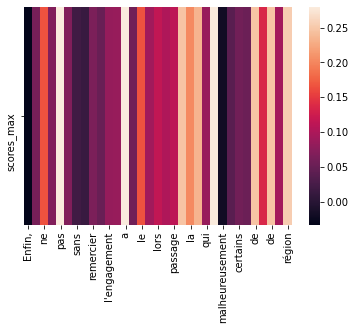

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np

 
# Default heatmap: just a visualization of this square matrix
 sns.heatmap(df_plot)


Faire des annotations pour la fin du doc et nettoyer mettre en forme
Faire des fonctions pour la fin 
Amélioer le graphique . Est ce que c'est intelligent par mot ? 
Remplacer score max par la moyenne des logits à chercher à la fin du train 
Analyser un peu et mettre au propre sur la feuille
